# Efficient Language Model Serving 






























In [45]:
### Import required packages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_colwidth', None)

import random
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

# Sentiment Analysis Dataset

In [14]:
# Load sample dataset
df = pd.read_csv("datasets/better30.csv")

df.head()

,CONVERSATION_ID,CONVERSATION_STEP,TEXT,CONTEXT,LABEL,FEATURES,ANNOTATIONS
0,6,1,"Good morning, this is [Your Name]'s personal assistant. How can I help you today?",Standard opening exchange,neutral,NaN,NaN
1,6,2,"Hello, my name is Jamie. I'm interested in volunteering... [Step: 1] Good morning, Jamie! It's wonderful to hear about your interest in volunteering. We're always looking for passionate individuals to join our efforts.",Encourages the caller's interest,neutral,"welcoming, positive_tone",NaN
2,6,3,"Yes, I'm really passionate about environmental conservation... [Step: 2] That's fantastic, Jamie. There are no specific requirements; we welcome volunteers of all backgrounds. The main need is for willingness to participate and follow the event guidelines for safety and effectiveness.",Reinforces anyone can volunteer,neutral,inclusive,NaN
3,6,4,"Great, how do I sign up, and where can I find more information... [Step: 3] You can sign up through our official website. There's a volunteer registration section where you'll find all the information about the event, including date, location, and what to bring. Would you like me to guide you to the webpage or send you the link?",Demonstrates flexibility,neutral,"helpful_tone, offers_options",NaN
4,6,5,"Could you send me the link, please? And my email is jamie.green@example.com. [Step: 4] Absolutely, Jamie. I'll send the link to your email along with additional resources about the event. You should receive it within a few minutes.",Fulfills caller's request quickly,neutral,prompt_action,NaN


In [15]:
df.CONVERSATION_ID.min(), df.CONVERSATION_ID.max()

(0, 68)

In [16]:
import random
conv_id=random.randint(0, 68)
print(conv_id)

random_conversation = '\n'.join(df[df.CONVERSATION_ID==conv_id].TEXT.values.tolist())

37


In [17]:
prompt_template = """Using the provided text below, perform a sentiment analysis of the text. \
Determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. \
Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".
Reply only with the sentiment analysis, no other comment.
\n
********** BEGIN TEXT **********
{text}
********** END TEXT **********
"""


In [18]:
prompt = prompt_template.format(text=random_conversation)
print(prompt)

Using the provided text below, perform a sentiment analysis of the text. Determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".
Reply only with the sentiment analysis, no other comment.


********** BEGIN TEXT **********
Hello, this is [Your Name]'s assistant. How may I direct your call today?
This is Alex from TechGuard Solutions. We've detected a severe security breach on your network that's putting your sensitive data at risk.
Can you specify what type of breach this is and how it was detected?
It's a sophisticated malware attack that was identified during our routine security scan. Immediate action is needed to secure your network.
Our security scans are managed internally. Can you provide evidence of the breach or a report of the scan?
I’m not authorized to share detailed reports over the phone. How

In [19]:
# Batch processing

batch = ["\n".join(df[df.CONVERSATION_ID==conv_id].TEXT.values.tolist()) for conv_id in range(68)]

batch = [prompt_template.format(text=p) for p in batch]

len(batch)


68

# Model: Mistral-7B-Instruct

In [ ]:
## Load Model: it will take few minutes if not cached

model_name = "mistralai/Mistral-7B-Instruct-v0.2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

print(model)

Task exception was never retrieved
future: <Task finished name='Task-6' coro=<predict() done, defined at /var/folders/tg/ry56nw9d1p98550kwhskdh4m0000gn/T/ipykernel_1134/1265475481.py:10> exception=RuntimeError('Session is closed')>
Traceback (most recent call last):
  File "/Users/santamm/.miniconda/envs/lorax/lib/python3.11/asyncio/tasks.py", line 277, in __step
    result = coro.send(None)
             ^^^^^^^^^^^^^^^
  File "/var/folders/tg/ry56nw9d1p98550kwhskdh4m0000gn/T/ipykernel_1134/1265475481.py", line 12, in predict
    async with session.post(url, json=prompt) as resp:
  File "/Users/santamm/.miniconda/envs/lorax/lib/python3.11/site-packages/aiohttp/client.py", line 1197, in __aenter__
    self._resp = await self._coro
                 ^^^^^^^^^^^^^^^^
  File "/Users/santamm/.miniconda/envs/lorax/lib/python3.11/site-packages/aiohttp/client.py", line 428, in _request
    raise RuntimeError("Session is closed")
RuntimeError: Session is closed
Task exception was never retrieved

In [33]:
model.get_memory_footprint()/1e9

30.0406784

In [12]:
prompt_template = """<s>[INST] Using the provided text below, analyze the sentiment expressed within it. \
Please determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. \
Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".
Reply only with the sentiment, no other comment.

********** BEGIN TEXT **********
{text}
********** END TEXT **********
[/INST]
"""

In [13]:
prompt = prompt_template.format(text=random_conversation)
print(prompt)

<s>[INST] Using the provided text below, analyze the sentiment expressed within it. Please determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".
Reply only with the sentiment, no other comment.

********** BEGIN TEXT **********
Hello, [Your Name]'s personal assistant speaking. How can I help?
This is Ryan from City Power, calling about an urgent issue with your electricity bill. Immediate payment is required to avoid disconnection.
I was unaware of any outstanding bill. Can you specify the amount and the billing period in question?
The outstanding amount is $450 for the last two months. We've sent several notices to your registered address without response.
To verify this, I'll need to check our records and get back to you. Can I have a contact number and reference for this call?
There's no time for tha

## Generate  tokens

In [61]:
%%time
# input prompt tokenization

inputs = tokenizer(prompt, return_tensors="pt").to(device)
inputs['input_ids'].size()

CPU times: user 2.73 ms, sys: 3.62 ms, total: 6.35 ms
Wall time: 5.58 ms


torch.Size([1, 625])

In [62]:
#inputs['input_ids']

In [63]:
## 3. Prefill and decode: optimizing token generation over multiple steps

### Text generation helper function
# The following helper function generates the next tokens given a set of input tokens

def generate_token(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id

In [64]:
%%timeit

token = generate_token(inputs)

In [65]:
tokenizer.decode(token)

'Ne'

In [66]:
# Use the helper function to generate multiple tokens in a loop
# Track the time it takes to generate each token

def generate_tokens(inputs, n_tokens):

    generated_tokens = []
    next_inputs = inputs
    durations_s = []
    for _ in range(n_tokens):
        t0 = time.time()
        next_token_id = generate_token(next_inputs)
        durations_s += [time.time() - t0]
    
        next_inputs = {
            "input_ids": torch.cat(
                [next_inputs["input_ids"], next_token_id.reshape((1, 1))],
                dim=1),
            "attention_mask": torch.cat(
                [next_inputs["attention_mask"], torch.tensor([[1]])],
                dim=1),
        }
    
        next_token = tokenizer.decode(next_token_id)
        generated_tokens.append(next_token)
    return "".join(generated_tokens), durations_s


tokens, durations = generate_tokens(inputs, 2)

211.53310704231262 s
['Ne', 'ut']


In [ ]:
print(tokens)

In [68]:
# Durations (secs)
durations

[102.44178605079651, 109.09132099151611]

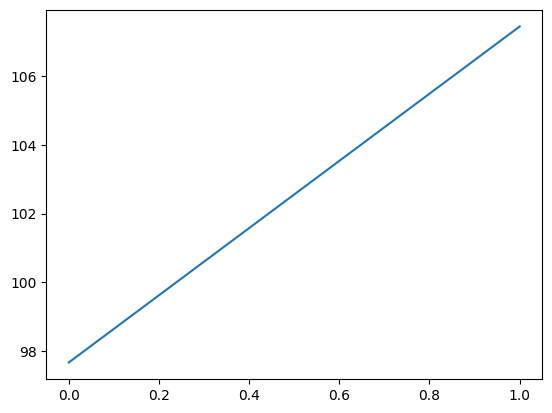

In [67]:
# Plot token generation time
# The x-axis here is the token number
# The y-axis is the time to generate a token in millisenconds (ms)
# **Note**: Your plot may vary slightly from the one shown in the video, yet it will exhibit a similar pattern.

plt.plot(durations_s)
plt.show()

### KV-caching

KV-caching is a technique to speed up token generation by storing some of the tensors in the attention head for use in subsequent generation steps


In [70]:
### Speeding up text generation with KV-caching
# KV-caching is a technique to speed up token generation by storing some of the tensors in the attention head for use in subsequent generation steps
# - Modify the generate helper function to return the next token and the key/value tensors

def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values


def generate_tokens_kv(inputs, n_tokens):
    generated_tokens = []
    next_inputs = inputs
    durations_cached_s = []
    for _ in range(n_tokens):
        t0 = time.time()
        next_token_id, past_key_values = \
            generate_token_with_past(next_inputs)
        durations_cached_s += [time.time() - t0]
    
        next_inputs = {
            "input_ids": next_token_id.reshape((1, 1)),
            "attention_mask": torch.cat(
                [next_inputs["attention_mask"], torch.tensor([[1]])],
                dim=1),
            "past_key_values": past_key_values,
        }
    
        next_token = tokenizer.decode(next_token_id)
        generated_tokens.append(next_token)
    return "".join(generated_tokens), durations_cached_s
    
    

In [71]:
# Generate tokens using the updated helper function

tokens, durations = generate_tokens_kv(inputs, 2)

print(f"{durations}")
print(tokens)

[105.08904910087585, 133.0786418914795]
['Ne', 'ut']


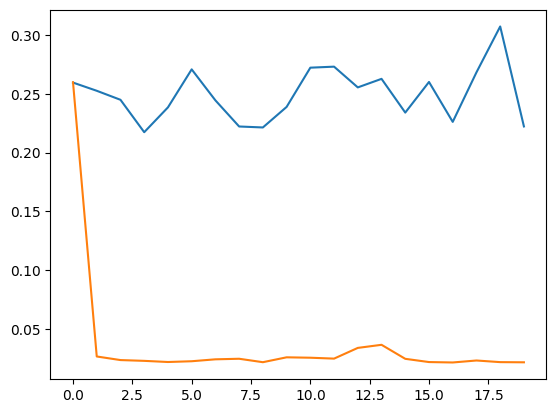

In [152]:
# Compare the execution time for the KV-cache function with the original helper function

# **Note**: Your plot may vary slightly from the one shown in the video, yet it will exhibit a similar pattern.

plt.plot(durations_s)
plt.plot(durations_cached_s)
plt.show()

## Batching

Tokenize list of prompts\
Add padding so that all prompts have the same number of tokens as the longest prompt

In [92]:
batch

['Using the provided text below, analyze the sentiment expressed within it. Please determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".\nReply only with the sentiment, no other comment.\n\n\n********** BEGIN TEXT **********\nHello, this is [Your Name]\'s personal assistant. How may I assist you today?\nHi, I\'m Sam. I saw an ad about a photography workshop hosted by [Your Name] next month. I\'m interested in registering but had a few questions. [Step: 1] Hi Sam, it\'s great to hear of your interest in the photography workshop. I\'d be happy to help with any questions you have.\nThanks! I was wondering about the skill level required for participants. I\'m fairly new to photography. [Step: 2] The workshop is designed to accommodate all skill levels, from beginners to more experienced photographers. [Your

In [108]:
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

# pad on the left so we can append new tokens on the right
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

In [109]:
# multiple prompts of varying lengths to send
# to the model at once
prompts = [prompt_template.format(text=text) for text in batch[:10]]

# note: padding=True ensures the padding token
# will be inserted into the tokenized tensors
inputs = tokenizer(prompts, padding=True, return_tensors="pt")

type(inputs)

transformers.tokenization_utils_base.BatchEncoding

In [110]:
inputs['input_ids'].size(), inputs["attention_mask"].size()

(torch.Size([10, 630]), torch.Size([10, 630]))

In [111]:
def generate_batch_tokens_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)
    return next_token_ids, outputs.past_key_values


# Generate all tokens for some max tokens
# position_ids tell the transformer the ordinal position of each token in the input sequence
# for single input inference, this is just [0 .. n]
# for n tokens, but for batch inference, we need to 0 out the padding tokens at the start of the sequence

def generate_batch(inputs, max_tokens):
    # create a list of tokens for every input in the batch
    generated_tokens = [
        [] for _ in range(inputs["input_ids"].shape[0])
    ]

    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)

    next_inputs = {
        "position_ids": position_ids,
        **inputs
    }

    for _ in range(max_tokens):
        next_token_ids, past_key_values = \
            generate_batch_tokens_with_past(next_inputs)

        next_inputs = {
            "input_ids": next_token_ids.reshape((-1, 1)),
            "position_ids": next_inputs["position_ids"][:, -1].unsqueeze(-1) + 1,
            "attention_mask": torch.cat([
                next_inputs["attention_mask"],
                torch.ones((next_token_ids.shape[0], 1)),  
            ], dim=1),
            "past_key_values": past_key_values,
        }

        next_tokens = tokenizer.batch_decode(next_token_ids)
        for i, token in enumerate(next_tokens):
            generated_tokens[i].append(token)
    return ["".join(tokens) for tokens in generated_tokens]

In [112]:
%%time

generated_tokens = generate_batch(inputs, max_tokens=10)

CPU times: user 19min 6s, sys: 20min 6s, total: 39min 12s
Wall time: 18min 57s


In [114]:
for prompt, generated in zip(prompts, generated_tokens):
    print(prompt, f"\x1b[31m{generated}\x1b[0m\n")

<s>[INST] Using the provided text below, analyze the sentiment expressed within it. Please determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".
Reply only with the sentiment, no other comment.

********** BEGIN TEXT **********
Using the provided text below, analyze the sentiment expressed within it. Please determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".
Reply only with the sentiment, no other comment.


********** BEGIN TEXT **********
Hello, this is [Your Name]'s personal assistant. How may I assist you today?
Hi, I'm Sam. I saw an ad about a photography workshop hosted by [Your Name] next month. I'm interested i

In [116]:
generated_tokens

['Positive</s>Byanalyzingtheconversationbetweenthe',
 'Positive</s>Byanalyzingthetext,the',
 'Negative</s>Byanalyzingthetext,the',
 'Neutral.Thetextexpressesaneutral',
 'Neutral.Thesentimentexpressedinthetext',
 'Neutral.Thetextisprimarilyfocusedon',
 'Positive.</s>Byusingwordslike"w',
 'Positive</s>Byanalyzingthetext,the',
 'Positive</s>ByassistingRobininresolving',
 'Positive</s>Byanalyzingthetext,the']

## Continuous Batching
The key idea behind continuous batching is constantly swap out requests from the batch that have completed generation for requests in the queue that are waiting to be processed.



![Continuous](ContinousBatching.jpg)

In [113]:
import helpers
from helpers import init_batch, generate_next_token
from helpers import merge_batches, filter_batch

In [ ]:
# seed the random number generator so our results are deterministic
random.seed(42)

# constants
queue_size = 32
batch_size = 8

# requests waiting to be processed
# requests are tuples (prompt, max_tokens)
request_queue = [
    (prompts[0], 100 if i % batch_size == 0 else 10)
    for i in range(queue_size)
]

In [ ]:
request_queue[:8]

In [ ]:
batches = [
    request_queue[i:i + batch_size]
    for i in range(0, len(request_queue), batch_size)
]

In [ ]:
len(batches)

In [ ]:
batches[0]

In [ ]:
# Processing batches

# generate tokens for all batches and record duration
t0 = time.time()
with tqdm(total=len(batches), desc=f"bs={batch_size}") as pbar:
    for i, batch in enumerate(batches):
        # to accommodate all the requests with our 
        # current implementation, we take the max of
        # all the tokens to generate among the requests
        batch_max_tokens = [b[1] for b in batch]
        max_tokens = max(batch_max_tokens)
        pbar.set_postfix({'max_tokens': max_tokens})
        
        batch_prompts = [b[0] for b in batch]
        inputs = tokenizer(
            batch_prompts, padding=True, return_tensors="pt")
        generate_batch(inputs, max_tokens=max_tokens)
        
        pbar.update(1)

duration_s = time.time() - t0
print("duration", duration_s)



In [ ]:
# Continuos batching

# seed the random number generator so our results are deterministic
random.seed(42)

# constants
queue_size = 32
batch_size = 8

# requests waiting to be processed
# this time requests are tuples (prompt, max_tokens)
request_queue = [
    (prompts[0], 100 if i % batch_size == 0 else 10)
    for i in range(queue_size)
]

t0 = time.time()
with tqdm(total=len(request_queue), desc=f"bs={batch_size}") as pbar:
    # first, let's seed the initial cached_batch
    # with the first `batch_size` inputs
    # and run the initial prefill step
    batch = init_batch(request_queue[:batch_size])
    cached_batch = generate_next_token(batch)
    request_queue = request_queue[batch_size:]

    # continue until both the request queue is 
    # fully drained and every input
    # within the cached_batch has completed generation
    while (
        len(request_queue) > 0 or
        cached_batch["input_ids"].size(0) > 0
    ):
        batch_capacity = (
            batch_size - cached_batch["input_ids"].size(0)
        )
        if batch_capacity > 0 and len(request_queue) > 0:
            # prefill
            new_batch = init_batch(request_queue[:batch_capacity])
            new_batch = generate_next_token(new_batch)
            request_queue = request_queue[batch_capacity:]

            # merge
            cached_batch = merge_batches(cached_batch, new_batch)

        # decode
        cached_batch = generate_next_token(cached_batch)

        # remove any inputs that have finished generation
        cached_batch, removed_indices = filter_batch(cached_batch)
        pbar.update(len(removed_indices))

duration_s = time.time() - t0
print("duration", duration_s)

## Quantized model

In [121]:
#!pip install accelerate

In [124]:
## Quantized Model

model_int8 = AutoModelForCausalLM.from_pretrained(model_name,
                                             #device_map='auto',
                                             load_in_8bit=True,
                                             )
print(f"Model size: {model_int8.get_memory_footprint():,} bytes")


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


ImportError: Using `bitsandbytes` 8-bit quantization requires Accelerate: `pip install accelerate` and the latest version of bitsandbytes: `pip install -i https://pypi.org/simple/ bitsandbytes`

In [ ]:
# Generate text with quantized model
text_int8 = generate_text(model_int8, prompt)

print(f"Original model:\n{original_text}")
print("-" * 50)
print(f"LLM.int8() model:\n{text_int8}")

## Mistral Quantized with llama-cpp

<img src="ZeroPointQuantization.jpg" width="500"/>

### Single Request

In [9]:
### Load quantized model

from llama_cpp import Llama
model_name = 'models/mistral-7b-instruct-v0.2.Q4_K_M.gguf'


model = Llama(
    model_path=model_name,
    n_ctx=32768,  # The max sequence length to use - note that longer sequence lengths require much more resources
    n_threads=8,            # The number of CPU threads to use, tailor to your system and the resulting performance
    n_gpu_layers=35,        # The number of layers to offload to GPU, if you have GPU acceleration available
    chat_format="llama-2"
)

llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from models/mistral-7b-instruct-v0.2.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:           

In [10]:
prompt

'Using the provided text below, analyze the sentiment expressed within it. Please determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".\nReply only with the sentiment, no other comment.\n\n\n********** BEGIN TEXT **********\nHello, [Your Name]\'s personal assistant speaking. How can I help?\nThis is Ryan from City Power, calling about an urgent issue with your electricity bill. Immediate payment is required to avoid disconnection.\nI was unaware of any outstanding bill. Can you specify the amount and the billing period in question?\nThe outstanding amount is $450 for the last two months. We\'ve sent several notices to your registered address without response.\nTo verify this, I\'ll need to check our records and get back to you. Can I have a contact number and reference for this call?\nThere\'s no time f

In [128]:
%%time


# Simple inference example
output = model(
  prompt, # Prompt
  max_tokens=32,  # Generate up to 32 tokens
  stop=["</s>"],   # Example stop token - not necessarily correct for this specific model! Please check before using.
  echo=True        # Whether to echo the prompt
)

# Chat Completion API

#llm = Llama(model_path="./mistral-7b-instruct-v0.2.Q4_K_M.gguf", chat_format="llama-2")  # Set chat_format according to the model you are using
#llm.create_chat_completion(
#    messages = [
##        {"role": "system", "content": "You are a story writing assistant."},
#        {
#            "role": "user",
#            "content": "Write a story about llamas."
#        }
#    ]
#)




llama_print_timings:        load time =   13013.76 ms
llama_print_timings:      sample time =       0.66 ms /     3 runs   (    0.22 ms per token,  4566.21 tokens per second)
llama_print_timings: prompt eval time =   13416.17 ms /   541 tokens (   24.80 ms per token,    40.32 tokens per second)
llama_print_timings:        eval time =     560.09 ms /     2 runs   (  280.04 ms per token,     3.57 tokens per second)
llama_print_timings:       total time =   14000.03 ms /   543 tokens


CPU times: user 23.9 ms, sys: 931 ms, total: 955 ms
Wall time: 14 s


In [131]:
output['choices'][0]['text']

'<s>[INST] Using the provided text below, analyze the sentiment expressed within it. Please determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".\nReply only with the sentiment, no other comment.\n\n********** BEGIN TEXT **********\nUsing the provided text below, analyze the sentiment expressed within it. Please determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".\nReply only with the sentiment, no other comment.\n\n\n********** BEGIN TEXT **********\nHello, this is the personal assistant of [Your Name]. How may I assist you today?\nHi, I\'m Chris...interested in the new line of eco-friendly kitchen products... [Step: 1

In [132]:
output['usage']

{'prompt_tokens': 541, 'completion_tokens': 2, 'total_tokens': 543}

### Batch Processing

Install llama-cpp-python: https://llama-cpp-python.readthedocs.io/en/latest/install/macos/ \
Launch the server\
config your ggml model path\
make sure it is gguf v2\
make sure it is q4_0

To istall with CUDA support:
CMAKE_ARGS="-DLLAMA_CUDA=on" pip install llama-cpp-python

Run the following:
```
export MODEL='models/mistral-7b-instruct-v0.2.Q4_K_M.gguf' 
python -m llama_cpp.server --model $MODEL  --n_gpu_layers -1
```

It will start a server on default port 8000:
```
Guessed chat format: mistral-instruct
INFO:     Started server process [64719]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://localhost:8000 (Press CTRL+C to quit)
```

In [98]:
batch = ["\n".join(df[df.CONVERSATION_ID==conv_id].TEXT.values.tolist()) for conv_id in range(68)]

batch = [prompt_template.format(text=p) for p in batch]

print(len(batch))

random_conversation = batch[random.randint(0,len(batch))]

print(random_conversation)


68
Using the provided text below, perfome a sentiment analysis of the text. Please determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".
Reply only with the sentiment analysis, no other comment.


********** BEGIN TEXT **********
Hello, this is the assistant of [Your Name]. How can I assist you today?
Hi, this is Agent Miller from the Cybersecurity Department. We’ve detected a breach in your digital accounts that could compromise your personal data.
That sounds serious. Can you specify which accounts are affected and what kind of breach has been detected?
It's a sophisticated hack that affects multiple accounts. We need immediate access to your systems to prevent any further damage.
For security reasons, we need to verify your identity first. Can you provide a contact number for your department?
We don’

In [ ]:
curl --request POST \
--url http://localhost:8080/completion \
--header "Content-Type: application/json" \
--data '{"prompt": ["<s>[INST] What is the capital of the US? [/INST]", "<s>[INST] What is the capital of France? [/INST]"], "n_predict": 2048}'

In [126]:
# Using Completions API

url = "http://localhost:8002/v1/completions"


prompt = {
  "prompt": f"\n\n### Instructions:\n{random_conversation}\n\n### Response:\n",
  "stop": [
    "\n",
    "###"
  ]
}



In [118]:
%%time
r = requests.post(url, json=prompt)

CPU times: user 4.11 ms, sys: 2.5 ms, total: 6.61 ms
Wall time: 343 ms


In [119]:
r.json()['choices'][0]['text']

'Negative'

In [20]:
prompts = [{
  "prompt": f"\n\n### Instructions:\n{conversation}\n\n### Response:\n",
  "stop": [
    "\n",
    "###"
  ]
} for conversation in batch
]

In [10]:
## Simulating Parallel Requests
from aiohttp import ClientSession
import asyncio

import nest_asyncio
nest_asyncio.apply()



# Initialize the async client

async def predict(session: ClientSession, prompt: str) -> str:
    print("Requesting", url)
    async with session.post(url, json=prompt) as resp:
        reply = await resp.json()
        #await sleep(2)  # for demo purposes
        #print("Got response from", url, text.strip().split("\n", 1)[0])
        preds.append(reply['choices'][0]['text'])
        #predicted_ms.append(reply['timings']['predicted_ms'])
        #tokens_per_second.append(reply['timings']['predicted_per_second'])
        
        

async def get_all(prompts: list[dict], num_concurrent: int) -> None:
    prompt_iterator = iter(prompts)
    keep_going = True
    async with ClientSession() as session:
        while keep_going:
            tasks = []
            for _ in range(num_concurrent):
                try:
                    nextone = next(prompt_iterator)
                except StopIteration:
                    keep_going = False
                    break
                new_task = asyncio.create_task(predict(session, nextone))
                tasks.append(new_task)
            await asyncio.gather(*tasks)
            

In [138]:
# Test single request

async with ClientSession() as session:
    await predict(session, url, prompt)

Requesting http://localhost:8002/v1/completions


In [139]:
predicted

['Negative.']

In [163]:
%%time

# Test small batch
preds, predicted_ms, tokens_per_second = [], [], []


event_loop = asyncio.get_event_loop()
event_loop.run_until_complete(get_all(prompts, 16))

Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/completions
Requesting http://localhost:8002/v1/comp

In [5]:
preds

NameError: name 'preds' is not defined

### Use llama.cpp server
For a detailed explanation of the server parameters, have a look [here](https://github.com/ggerganov/llama.cpp/blob/master/examples/server/README.md)




```
./server --model ../ServingLLMs/models/mistral-7b-instruct-v0.2.Q4_K_M.gguf --port 8080 -c 8092 -cb -np 16
```
- cb: continuous batching
- np: number of slots (parallelism)


In [66]:
url = "http://localhost:8080/v1/completions"

prompts = [{
    "prompt": f"\n\n### Instructions:\n{conversation}\n\n### Response:\n",
    "n_predict":4,
    "stop": [
        "\n",
        "###"
      ]
} for conversation in batch
]



In [67]:
prompts[0]

{'prompt': '\n\n### Instructions:\nUsing the provided text below, perform a sentiment analysis of the text. Determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".\nReply only with the sentiment analysis, no other comment.\n\n\n********** BEGIN TEXT **********\nHello, this is [Your Name]\'s personal assistant. How may I assist you today?\nHi, I\'m Sam. I saw an ad about a photography workshop hosted by [Your Name] next month. I\'m interested in registering but had a few questions. [Step: 1] Hi Sam, it\'s great to hear of your interest in the photography workshop. I\'d be happy to help with any questions you have.\nThanks! I was wondering about the skill level required for participants. I\'m fairly new to photography. [Step: 2] The workshop is designed to accommodate all skill levels, from beginners to mor

In [109]:
async def predict(session: ClientSession, prompt: str) -> str:
    print("Requesting", url)
    async with session.post(url, json=prompt) as resp:
        reply = await resp.json()
        #await sleep(2)  # for demo purposes
        #print("Got response from", url, text.strip().split("\n", 1)[0])
        preds.append(reply['content'])
        preds_ms.append(reply['timings']['prompt_ms']+reply['timings']['predicted_ms'])
        tokens_per_second.append(reply['timings']['predicted_per_second'])

async def get_all(prompts: list[dict], num_concurrent: int) -> None:
    prompt_iterator = iter(prompts)
    keep_going = True
    async with ClientSession() as session:
        while keep_going:
            tasks = []
            for _ in range(num_concurrent):
                try:
                    nextone = next(prompt_iterator)
                except StopIteration:
                    keep_going = False
                    break
                new_task = asyncio.create_task(predict(session, nextone))
                tasks.append(new_task)
            await asyncio.gather(*tasks)




In [106]:
prompt = prompts[random.randint(0, len(prompts))]
prompt



{'prompt': '\n\n### Instructions:\nUsing the provided text below, perform a sentiment analysis of the text. Determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".\nReply only with the sentiment analysis, no other comment.\n\n\n********** BEGIN TEXT **********\nHello, this is the assistant to [Your Name]. How may I assist you today?\nGood day! I\'m Sarah from the Global Aid Foundation. We\'re currently running a campaign to support victims of the recent natural disaster in [Region]. We\'re reaching out to compassionate individuals like [Your Name] for support.\nAbsolutely. Our foundation has been actively involved in various relief efforts worldwide. This particular campaign focuses on providing shelter, food, and medical supplies to the affected individuals in [Region].\nWe\'re in the process of updating

In [112]:
# Single test
async with ClientSession() as session:
    async with session.post(url, json=prompt) as resp:
        reply = await resp.json()

f"Replied: {reply['content']} in {reply['timings']['prompt_ms']+reply['timings']['predicted_ms']} ms."

'Replied: Positive. The in 2674.2490000000003 ms.'

In [107]:
#reply

In [113]:
%%time

# Test small batch
preds, preds_ms, tokens_per_second = [], [], []


event_loop = asyncio.get_event_loop()
event_loop.run_until_complete(get_all(prompts, 1))

Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/comp

In [115]:
def results(preds, preds_ms, tokens_per_second):
    failed = len([i for i, v in enumerate(preds) if not v])
    predicted = len([i for i, v in enumerate(preds) if v])
    mean_pred_ms = np.mean([p for i, p in enumerate(preds_ms) if preds[i]])
    mean_tokens_pre_sec = np.mean([p for i, p in enumerate(tokens_per_second) if preds[i]])

    print(f"Succesfull predictions: {predicted}")
    print(f"Failed predictions: {failed}")
    print(f"Mean prediction time: {mean_pred_ms} ms")
    print(f"Mean Tokens per second: {mean_tokens_pre_sec}")

results(preds, preds_ms, tokens_per_second)

Succesfull predictions: 64
Failed predictions: 4
Mean prediction time: 2982.183359375 ms
Mean Tokens per second: 24.676606608705075


Server params: ./server --model ../ServingLLMs/models/mistral-7b-instruct-v0.2.Q4_K_M.gguf --port 8080 -c 8092 

num_concurrent = 4: 
- Wall time: 2min 58s
- Succesfull predictions: 65
- Failed predictions: 3
- Mean prediction time: 128.7569230769231 ms
- Mean Tokens per second: 30.36970070698698

num_concurrent = 8:
- Wall time: 2min 58s
- Succesfull predictions: 67
- Failed predictions: 1
- Mean prediction time: 125.69899999999998 ms
- Mean Tokens per second: 30.712767388238678

num_concurrent = 16:
- Wall time: 2min 57s
- Succesfull predictions: 68
- Failed predictions: 0
- Mean prediction time: 127.74423529411763 ms
- Mean Tokens per second: 30.5376105211548

num_concurrent = 32:
- Wall time: 2min 57s
- Succesfull predictions: 68
- Failed predictions: 0
- Mean prediction time: 128.52476470588238 ms
- Mean Tokens per second: 30.465315738074697



In [95]:
178/67

2.656716417910448

## Lorax

In [ ]:
from lorax import AsyncClient


# Batch of prompts to submit
prompts = [
    "The quick brown fox",
    "The rain in Spain",
    "What comes up",
]

# Initialize the async client
endpoint_url = "http://127.0.0.1:8080"
async_client = AsyncClient(endpoint_url)

# Submit all prompts and do not block on the response
t0 = time.time()
futures = []
for prompt in prompts:
    resp = async_client.generate(prompt, max_new_tokens=64)
    futures.append(resp)

# Await the completion of all the prompt requests
responses = await asyncio.gather(*futures)

# Print responses
# Responses will always come back in the same order as the original list
for resp in responses:
    print(resp.generated_text)

# Print duration to process all requests in batch
print("duration (s):", time.time() - t0)

# Finetuned Mistral: Zephyr-7b-dpo-qlora
[zephyr-7b-dpo-qlora](https://huggingface.co/alignment-handbook/zephyr-7b-dpo-qlora/tree/main)


Mistral-7b fine-tuned on Zephyr-7B dataset with DPO, a dataset of conversations. So this is a Mistral-7B finetuned to be an helpful assistant.\
The model has been finetuned using the [PEFT](https://huggingface.co/docs/peft/en/index) library.



In [134]:
#!pip install peft

In [ ]:
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM

config = PeftConfig.from_pretrained("alignment-handbook/zephyr-7b-dpo-qlora")
model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1")
model = PeftModel.from_pretrained(model, "alignment-handbook/zephyr-7b-dpo-qlora")

Loading checkpoint shards:   0%|                                                                  | 0/2 [00:00<?, ?it/s]